# Optimizing an Additive Synthesizer

- Introduce the concept of a frame rate parameter
- Introduce STFT loss
- Introduce Multi-resolution STFT Loss

In [1]:
from typing import List

import torch
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import trange

import librosa
import crepe
import auraloss

In [2]:
# Load audio
audio, sample_rate = torchaudio.load('../audio/guitar_acoustic_014-048-100.wav')

# Extract the first 3.25 seconds of the audio (chop silence from the end)
audio = audio[:, :int(sample_rate * 2.0)]

ipd.Audio(audio.numpy(), rate=sample_rate)

7/7 [==============================] - 2s 217ms/step
tensor(130.1843, dtype=torch.float64) tensor(131.7103, dtype=torch.float64)
torch.Size([1, 201])


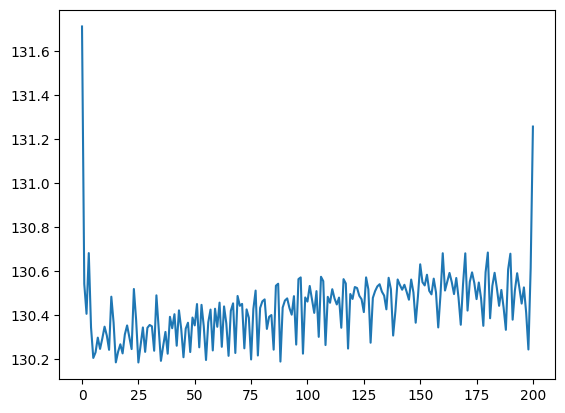

In [3]:
frame_rate = 100 # Hz
f0 = torchaudio.functional.detect_pitch_frequency(audio, sample_rate, frame_time=1.0 / frame_rate, win_length=30)

hop_length = int(sample_rate / frame_rate)
f0, _, _ = librosa.pyin(audio.numpy()[0], fmin=50, fmax=2000, sr=sample_rate, hop_length=hop_length)
f0 = torch.from_numpy(f0).unsqueeze(0)
f0 = torch.nan_to_num(f0, nan=0.0)

time, frequency, confidence, activation = crepe.predict(audio.numpy()[0], sample_rate, viterbi=True)
f0 = torch.from_numpy(frequency).unsqueeze(0)

plt.plot(f0[0].numpy())
print(f0.min(), f0.max())

print(f0.shape)

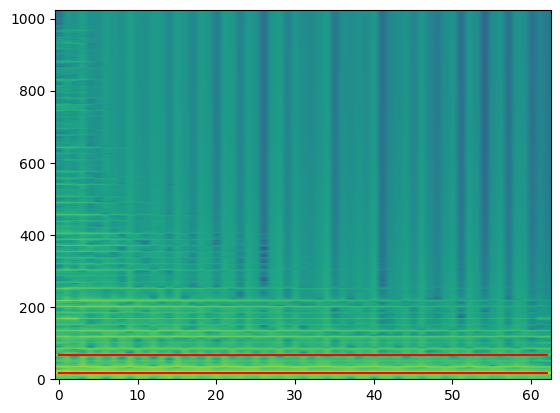

In [4]:
X = torch.stft(audio, n_fft=2048, hop_length=512, return_complex=True)
X_mag = torch.abs(X)
X_db = 20.0 * torch.log10(X_mag + 1e-6)

plt.imshow(X_db[0].numpy(), aspect='auto', origin='lower')

f0_bins = f0 * 2048 / sample_rate
f0_bins = f0_bins.unsqueeze(0)
f0_bins = torch.nn.functional.interpolate(f0_bins, size=X_db.shape[2], mode='linear')
plt.plot(f0_bins[0,0].numpy(), 'r')
plt.plot(f0_bins[0,0].numpy() * 4.0, 'r')

# TODO - fix the scaling on this
y_ticks = plt.yticks()
y_tick = torch.logspace(5, 13, 6, base=2.0)


In [5]:
def additive_synth(
    frequencies: torch.Tensor,  # Angular frequencies (rad / sample) - frame rate
    amplitudes: torch.Tensor,  # Amplitudes
    n_samples: int,  # Number of samples to synthesize
):
    assert frequencies.ndim == 3, "Frequencies must be 3D (batch, n_frequencies, n_frames)"
    assert frequencies.shape == amplitudes.shape, "Frequency and amplitude shapes must match"

    # Upsample frequency and amplitude envelopes to sample rate
    f_up = torch.nn.functional.interpolate(frequencies, size=n_samples, mode="linear")
    a_up = torch.nn.functional.interpolate(amplitudes, size=n_samples, mode="linear")

    # Set initial phase to zero, prepend to frequency envelope
    initial_phase = torch.zeros_like(f_up[:, :, :1])
    f_up = torch.cat([initial_phase, f_up], dim=-1)

    # Create the phase track and remove the last sample (since we added initial phase)
    phase = torch.cumsum(f_up, dim=-1)[..., :-1]
    y = torch.sin(phase) * a_up
    y = torch.sum(y, dim=1)
    return y

In [6]:
def remove_above_nyquist(frequencies, amplitudes):
    mask = torch.where(frequencies >= torch.pi, 0.0, 1.0)
    return amplitudes * mask

In [7]:
def harmonic_synth(
  f0: torch.Tensor,  # Fundamental frequency (Hz) (batch, n_samples)
  harmonic_amps: torch.Tensor,  # Amplitudes of harmonics (batch, n_harmonics, n_samples)
  num_samples: int,  # Number of samples to synthesize
  global_amp: torch.Tensor = None,  # Global amplitude, applied to all partials
  normalize: bool = True,
):
    assert f0.ndim == 2, "Fundamental frequency must be 2D (batch, n_samples)"
    assert harmonic_amps.ndim == 3, "Harmonic amplitudes must be 3D (batch, n_harmonics, n_samples)"

    num_harmonics = harmonic_amps.shape[1]

    # Create integer harmonic ratios and reshape to (1, n_harmonics, 1) so we can
    # multiply with fundamental frequency tensor repeated for num_harmonics
    harmonic_ratios = torch.arange(1, num_harmonics + 1).view(1, -1, 1)

    # Duplicate the fundamental frequency for each harmonic
    frequency = f0.unsqueeze(1).repeat(1, num_harmonics, 1)

    # Multiply the fundamental frequency by the harmonic ratios
    frequency = frequency * harmonic_ratios

    # Remove frequencies above Nyquist
    harmonic_amps = remove_above_nyquist(frequency, harmonic_amps)
    # assert torch.max(frequency) < torch.pi, f"Frequency must be less than pi, got {torch.max(frequency)}"

    # Normalize amplitudes to sum to 1 at each sample
    if normalize:
      harmonic_amps = torch.abs(harmonic_amps)
      harmonic_amps = harmonic_amps / torch.sum(harmonic_amps, dim=1, keepdim=True)
    
    # If no global amplitude is provided, apply a static amplitude of 1
    if global_amp is not None:
      harmonic_amps = harmonic_amps * global_amp.unsqueeze(1)

    return additive_synth(frequency, harmonic_amps, num_samples)

In [8]:
# Convert to angular frequency
w0 = f0 * 2 * torch.pi / sample_rate

In [9]:
num_harmonics = 101

# Random amplitudes for each harmonic
amplitudes = torch.ones(num_harmonics)
amplitudes = torch.ones(1, num_harmonics, w0.shape[-1]) * amplitudes.view(1, -1, 1)

In [10]:
print(w0.shape, amplitudes.shape)

torch.Size([1, 201]) torch.Size([1, 101, 201])


In [11]:
y = harmonic_synth(w0, amplitudes, audio.shape[-1])

In [12]:
ipd.Audio(y[0].numpy(), rate=sample_rate)

In [13]:
class MultiResolutionSTFT(torch.nn.Module):

    def __init__(self, n_fft: List[int], hop_size: List[int]):
        super().__init__()
        assert len(n_fft) == len(hop_size), "n_fft and hop_size must have the same length"

        self.n_fft = n_fft
        self.hop_size = hop_size
        self.eps = 1e-8
    
    def forward(self, y: torch.Tensor, y_pred: torch.Tensor):

        # Compute the STFT for each resolution
        error = []
        for n_fft, hop_size in zip(self.n_fft, self.hop_size):
            Y = torch.stft(y, n_fft=n_fft, hop_length=hop_size, window=torch.hann_window(n_fft), return_complex=True)
            Y_pred = torch.stft(y_pred, n_fft=n_fft, hop_length=hop_size, window=torch.hann_window(n_fft), return_complex=True)

            error_mag = torch.nn.functional.l1_loss(torch.abs(Y), torch.abs(Y_pred), reduction='mean')
            error_log = torch.nn.functional.l1_loss(torch.log10(torch.abs(Y) + self.eps), torch.log10(torch.abs(Y_pred) + self.eps), reduction='mean')
            error.append(error_mag + error_log)

        return torch.stack(error).sum()



In [14]:
n_ffts = [2048, 1024, 512, 256, 128, 64]
n_ffts = [2048,]
hop_sizes = [n//4 for n in n_ffts]

loss_fn = MultiResolutionSTFT(n_fft=n_ffts, hop_size=hop_sizes)

loss_fn = auraloss.freq.MultiResolutionSTFTLoss(fft_sizes=n_ffts, hop_sizes=hop_sizes, win_lengths=n_ffts, w_lin_mag=1.0, w_log_mag=1.0, w_sc=0.0)

In [15]:
amp_param = torch.nn.Parameter(torch.rand_like(amplitudes))
global_amp = torch.nn.Parameter(torch.rand_like(w0))

optimizer = torch.optim.Adam([amp_param, global_amp], lr=0.005)

In [16]:
loss_log = []
t = trange(1000, desc="Error", leave=True)
for i in t:
    # 1. Compute a forward pass using our learned parameter
    y_pred = harmonic_synth(w0, amp_param, audio.shape[-1], global_amp=global_amp)

    # 2. Compute the MAE loss directly on the time domain signal
    loss = loss_fn(audio.unsqueeze(0), y_pred.unsqueeze(0))

    # Store the current loss value for plotting later
    loss_log.append(loss.item())

    # 3. Reset gradients
    optimizer.zero_grad()

    # 4. Compute the gradients
    loss.backward()

    # 5. Update the parameters
    optimizer.step()

    t.set_description(f"Error: {loss.detach().cpu().numpy()}")
    t.refresh()

Error: 2.0942477718833743: 100%|██████████| 1000/1000 [00:29<00:00, 33.51it/s]


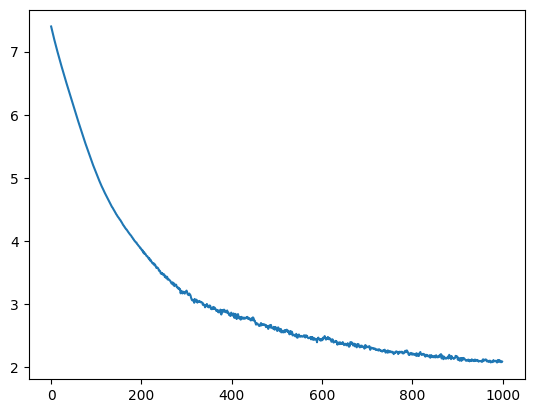

In [17]:
plt.plot(loss_log)

In [18]:
ipd.Audio(y_pred[0].detach().numpy(), rate=sample_rate)

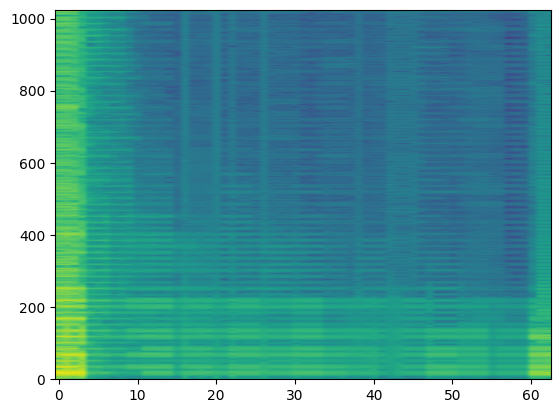

In [19]:
X = torch.stft(y_pred.detach(), n_fft=2048, hop_length=512, return_complex=True)
X_mag = torch.abs(X)
X_db = 20.0 * torch.log10(X_mag)

plt.imshow(X_db[0].numpy(), aspect='auto', origin='lower')


# TODO - fix the scaling on this
y_ticks = plt.yticks()
y_tick = torch.logspace(5, 13, 6, base=2.0)

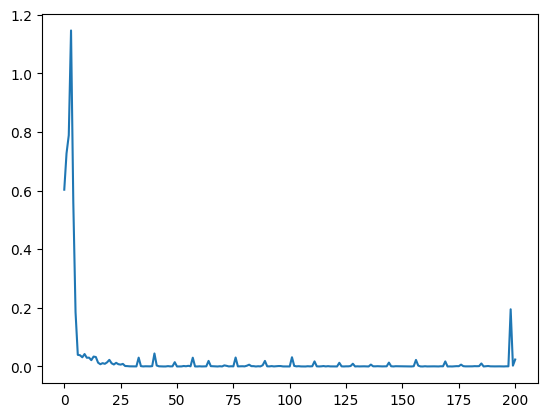

In [20]:
plt.plot(torch.abs(global_amp[0]).detach().numpy())